# Bayes fit of atmospheric models to an observed spectrum

Compare the Sonora Elf Owl models to a near-infrared spectrum for a late-T brown dwarf (~750 K)

In [1]:
from astropy.io import fits, ascii
import seda # import the seda package
import importlib # to reload modules
import numpy as np


    SEDA package imported


/home/gsuarez/TRABAJO/PROGRAMS/Anaconda/anaconda3/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Read the near-infrared spectrum from IRTF/SpeX for the T8 brown dwarf 2MASS J04151954-0935066 from Burgasser et al. (2004)

In [2]:
# SpeX spectrum
SpeX_name = 'data/IRTF_SpeX_0415-0935.dat'
SpeX = ascii.read(SpeX_name)
wl_SpeX = SpeX['wl(um)'] # um 
flux_SpeX = SpeX['flux(erg/s/cm2/A)'] # erg/s/cm2/A
eflux_SpeX = SpeX['eflux(erg/s/cm2/A)'] # erg/s/cm2/A

Read SEDA input data

In [3]:
# input spectrum
wl_spectra = wl_SpeX
flux_spectra = flux_SpeX
eflux_spectra = eflux_SpeX
res = 100 # spectral resolution of input spectrum to convolve model spectra
lam_res = 2.0 # (um) reference wavelength to get the above resolution for model spectra
d_target = 5.71 # pc (parallax=175.2+-1.7; Dupuy-Liu2012)
ed_target = 0.06 # pc

my_data = seda.InputData(wl_spectra=wl_spectra, flux_spectra=flux_spectra, distance=d_target, 
                         eflux_spectra=eflux_spectra, res=res, lam_res=lam_res)


Input data loaded successfully


Read model grid options

In [4]:
model = 'Sonora_Elf_Owl'
model_dir = ['/home/gsuarez/TRABAJO/MODELS/atmosphere_models/Sonora_Elf_Owl/spectra/output_575.0_650.0/',
             '/home/gsuarez/TRABAJO/MODELS/atmosphere_models/Sonora_Elf_Owl/spectra/output_700.0_800.0/',
            ] # all spectra in the indicated folders (and meeting the criteria below) will be used

Teff_range = np.array((700, 900)) # Teff range
logg_range = np.array((4.0, 5.0)) # logg range
R_range = np.array((0.6, 1.0)) # Rjup

my_model = seda.ModelOptions(model=model, model_dir=model_dir, 
                             logg_range=logg_range, Teff_range=Teff_range, R_range=R_range)


Model options loaded successfully


Read Bayes fit options

In [5]:
grid = seda.utils.read_grid(model=model, Teff_range=Teff_range, logg_range=logg_range)


   reading model grid...


/home/gsuarez/TRABAJO/PROGRAMS/Anaconda/anaconda3/lib/python3.9/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


      3000 spectra in memory to define a grid for interpolations
         elapsed time: 20.0 s


In [6]:
# importlib.reload(seda.input_parameters) # to automatically reload any changes in the function
# importlib.reload(seda) # to automatically reload any changes in the function

# Teff_range_pos = np.array((750, 850)) # Teff range
# logg_range_pos = np.array((4.1, 4.9)) # logg range
# logKzz_range_pos = np.array((2.1, 5.))
# Z_range_pos = np.array((-0.5, 0.5))
# CtoO_range_pos = np.array((0.7, 2.))
# Teff_range_pos = np.array((750, 850)) # Teff range
# logg_range_pos = np.array((4.5, 4.5)) # logg range
# logKzz_range_pos = np.array((4., 4.))
# Z_range_pos = np.array((0., 0.))
# CtoO_range_pos = np.array((1., 1.))

my_bayes = seda.BayesOptions(my_data=my_data, my_model=my_model, grid=grid,
#                              logKzz_range=logKzz_range_pos, Z_range=Z_range_pos, CtoO_range=CtoO_range_pos, 
                             dynamic_sampling=False)

# my_bayes = seda.BayesOptions(my_data=my_data, my_model=my_model)


Bayes fit options loaded successfully


In [7]:
importlib.reload(seda.bayes_fit) # to automatically reload any changes in the function
importlib.reload(seda) # to automatically reload any changes in the function

out_bayes = seda.bayes(my_bayes)


Estimating Bayesian posteriors...


   Uniform priors:
      Teff range = [700 900]
      logg range = [4. 5.]
      logKzz range = [2. 9.]
      Z range = [-1.  1.]
      CtoO range = [0.5 2.5]
      R range = [0.6 1. ]


16656it [5:18:24,  1.15s/it, +500 | bound: 149 | nc: 1 | ncall: 130019 | eff(%): 13.246 | loglstar:   -inf < 10063.408 <    inf | logz: 10030.764 +/-  0.258 | dlogz:  0.001 >  0.509]

   nested sampling results saved successfully
   elapsed time running bayes_fit: 5.3 hr


C/O ratio is fix below

In [21]:
importlib.reload(seda.bayes_fit) # to automatically reload any changes in the function
importlib.reload(seda) # to automatically reload any changes in the function

out_bayes = seda.bayes(my_bayes)


Estimating Bayesian posteriors...


   Uniform priors:
      Teff range = [700 900]
      logg range = [4. 5.]
      logKzz range = [2. 9.]
      Z range = [-1.  1.]
      CtoO range = [1. 1.]
      R range = [0.6 1. ]


13091it [2:13:20,  1.64it/s, +500 | bound: 79 | nc: 1 | ncall: 76952 | eff(%): 17.777 | loglstar:   -inf < 9835.815 <    inf | logz: 9810.330 +/-  0.226 | dlogz:  0.001 >  0.509]

   nested sampling results saved successfully
   elapsed time running bayes_fit: 2.2 hr


In [26]:
# import pickle

# # load saved variable with model grid
# # sresults = None

# # open the file in binary mode
# with open('Sonora_Elf_Owl_nested_sampling.pickle', 'rb') as file:
#     # deserialize and retrieve the variable from the file
#     sresults = pickle.load(file)

# print('variable loaded successfully')

Quantiles:
Teff (K) [(0.025, 768.1827768254469), (0.5, 769.8964728497874), (0.975, 771.6291860404143)]
Quantiles:
logg [(0.025, 4.544244102815733), (0.5, 4.554319520432623), (0.975, 4.563900662924726)]
Quantiles:
logKzz [(0.025, 2.7431742579993785), (0.5, 2.8395541774217437), (0.975, 2.942662267837939)]
Quantiles:
Z [(0.025, 0.08426879349268483), (0.5, 0.08840893233893413), (0.975, 0.09280239325963259)]
Quantiles:
C/O [(0.025, 1.0), (0.5, 1.0), (0.975, 1.0)]
Quantiles:
R (Rj) [(0.025, 0.7816160051640174), (0.5, 0.7858843864278159), (0.975, 0.7901118587507299)]


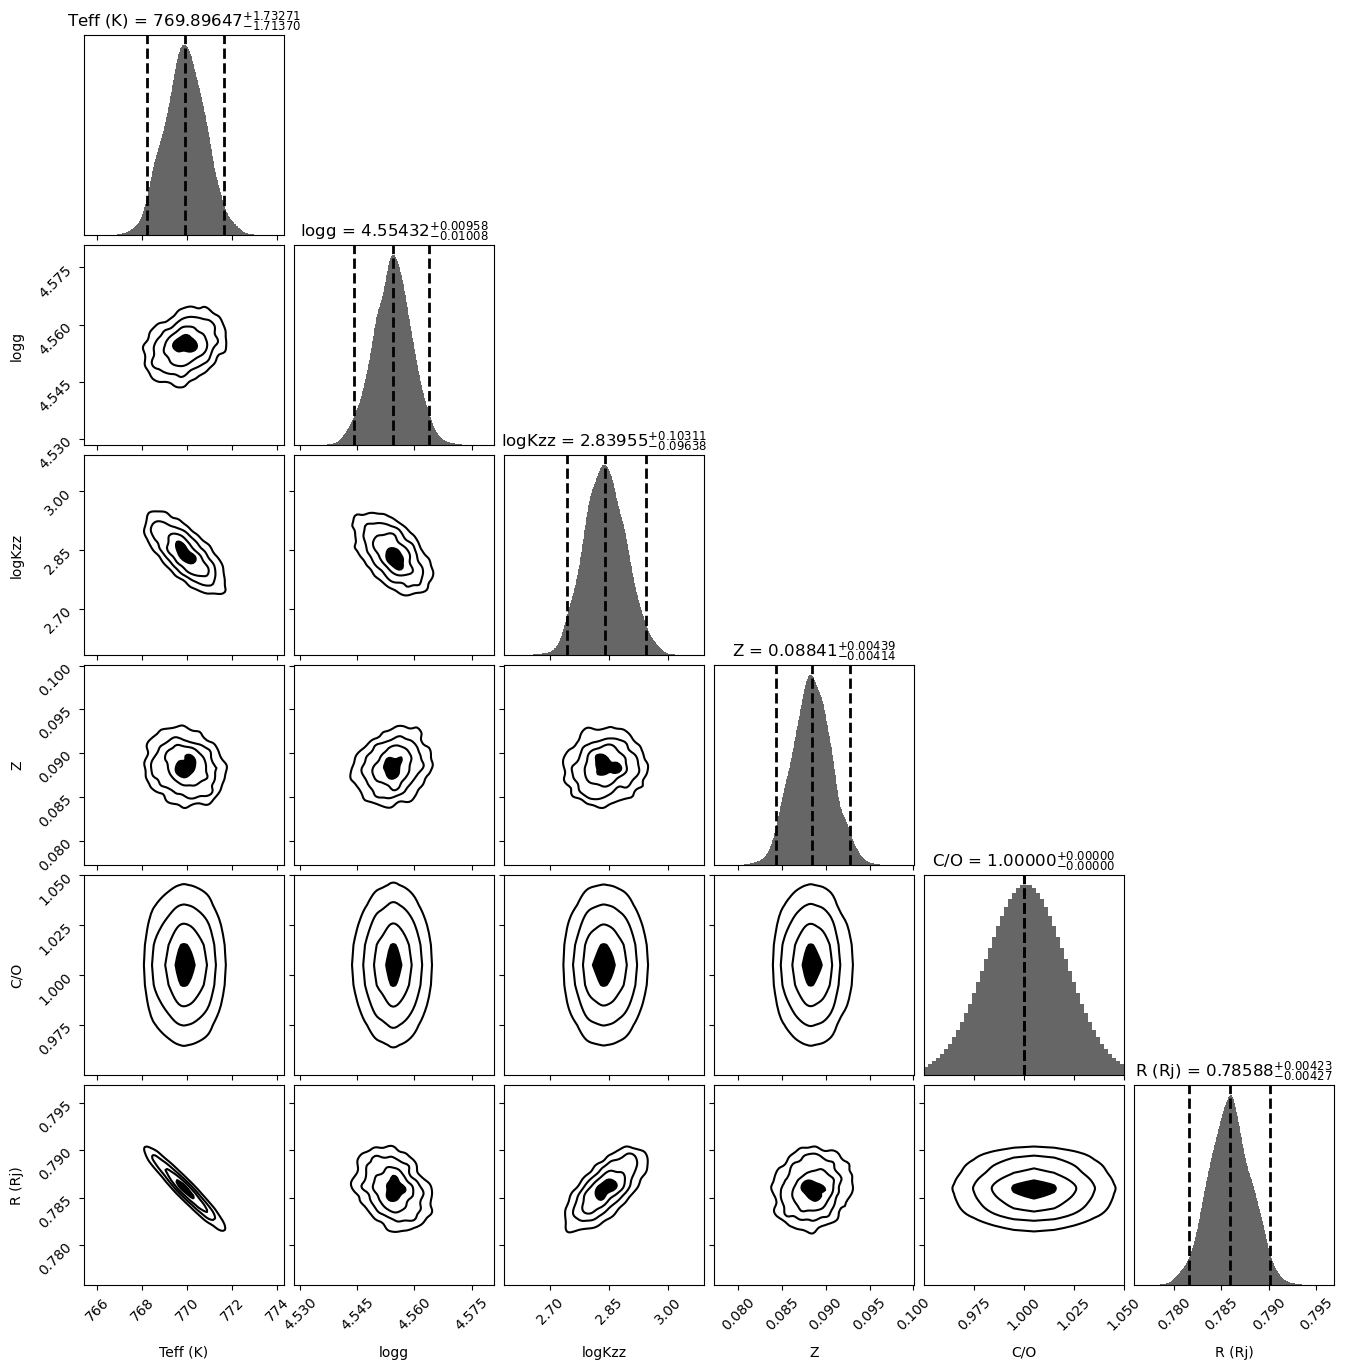

In [27]:
from dynesty import plotting as dyplot
from matplotlib import pyplot as plt

# truths = ['1.1', '790', '4.5', '2']
labels = ['Teff (K)', 'logg', 'logKzz', 'Z', 'C/O', 'R (Rj)']
fig, axes = dyplot.cornerplot(out_bayes, show_titles=True, #truths=truths, 
                              verbose='true', title_fmt='.5f', #, #.1f, .2f, .1f',
                              title_kwargs={'y': 1.0}, labels=labels)
#                               fig=plt.subplots(ndim, ndim, figsize=(7, 7)))

In [22]:
# import interpol_model as interpol_model
# import seda as seda
# import importlib

importlib.reload(seda.interpol_model) # to reload the module
importlib.reload(seda) # to reload the seda package with the updated module

# importlib.reload(interpol_model) # to automatically reload any changes in the function
# importlib.reload(seda) # to automatically reload any changes in the function
grid = seda.interpol_model.read_grid(model=model, Teff_range=Teff_range, logg_range=logg_range)


   reading model grid...


/home/gsuarez/TRABAJO/PROGRAMS/Anaconda/anaconda3/lib/python3.9/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


      3000 spectra in memory to define a grid for interpolations
         elapsed time: 27.0 s


Run Dynesty

In [98]:
importlib.reload(seda.bayes_fit) # to reload the module
importlib.reload(seda) # to reload the seda package with the updated module

R_range = np.array((0.6, 1.0)) # Rjup
d_target = 5.71 # pc (parallax=175.2+-1.7; Dupuy-Liu2012)
ed_target = 0.06 # pc

Teff_range_pos = np.array((750, 850)) # Teff range
logg_range_pos = np.array((4.1, 4.9)) # logg range
logKzz_range_pos = np.array((2.1, 5.))
Z_range_pos = np.array((-0.5, 0.5))
CtoO_range_pos = np.array((0.7, 2.))
# Teff_range_pos = np.array((750, 850)) # Teff range
# logg_range_pos = np.array((4.5, 4.5)) # logg range
# logKzz_range_pos = np.array((4., 4.))
# Z_range_pos = np.array((0., 0.))
# CtoO_range_pos = np.array((1., 1.))

out_sampling = seda.bayes_fit.sampling(grid=grid, wl_spectra=wl_spectra, flux_spectra=flux_spectra, 
                                       eflux_spectra=eflux_spectra, Teff_range=Teff_range_pos, 
                                       logg_range=logg_range_pos, R_range=R_range, 
                                       logKzz_range=logKzz_range_pos, Z_range=Z_range_pos,
                                       CtoO_range=CtoO_range_pos, model=model,
                                       lam_res=lam_res, res=res, distance=d_target, dynamic=False)


Sample posteriors
   Uniform priors:
      Teff range = [750 850]
      logg range = [4.1 4.9]
      logKzz range = [2.1 5. ]
      Z range = [-0.5  0.5]
      CtoO range = [0.7 2. ]
      R range = [0.6 1. ]

Estimating posteriors...


15234it [5:28:55,  1.30s/it, +500 | bound: 125 | nc: 1 | ncall: 112797 | eff(%): 14.011 | loglstar:   -inf < 10063.653 <    inf | logz: 10033.827 +/-  0.246 | dlogz:  0.001 >  0.509]

   nested sampling results saved successfully
   elapsed time running bayes_fit: 5.5 hr


In [103]:
importlib.reload(seda.bayes_fit) # to reload the module
importlib.reload(seda) # to reload the seda package with the updated module

R_range = np.array((0.6, 1.0)) # Rjup
d_target = 5.71 # pc (parallax=175.2+-1.7; Dupuy-Liu2012)
ed_target = 0.06 # pc

# Teff_range_pos = np.array((750, 850)) # Teff range
# logg_range_pos = np.array((4.1, 4.9)) # logg range
# logKzz_range_pos = np.array((2.1, 5.))
# Z_range_pos = np.array((-0.5, 0.5))
# CtoO_range_pos = np.array((0.7, 2.))
Teff_range_pos = np.array((750, 850)) # Teff range
logg_range_pos = np.array((4.5, 4.5)) # logg range
logKzz_range_pos = np.array((4., 4.))
Z_range_pos = np.array((0., 0.))
CtoO_range_pos = np.array((1., 1.))

out_sampling = seda.bayes_fit.sampling(grid=grid, wl_spectra=wl_spectra, flux_spectra=flux_spectra, 
                                       eflux_spectra=eflux_spectra, Teff_range=Teff_range_pos, 
                                       logg_range=logg_range_pos, R_range=R_range, 
#                                        logKzz_range=logKzz_range_pos, Z_range=Z_range_pos,
                                       CtoO_range=CtoO_range_pos, model=model,
                                       lam_res=lam_res, res=res, dynamic=False)


Sample posteriors
   Uniform priors:
      Teff range = [750 850]
      logg range = [4.5 4.5]
      logKzz range = [4. 4.]
      Z range = [0. 0.]
      CtoO range = [1. 1.]

Estimating posteriors...


2632it [1:03:50,  1.46s/it, +500 | bound: 3 | nc: 1 | ncall: 20292 | eff(%): 15.825 | loglstar:   -inf < 8923.675 <    inf | logz: 8919.318 +/-  0.075 | dlogz:  0.001 >  0.509]

   nested sampling results saved successfully
   elapsed time running bayes_fit: 1.1 hr


In [17]:
import pickle

# load saved variable with model grid
# sresults = None

# open the file in binary mode
with open('Sonora_Elf_Owl_nested_sampling.pickle', 'rb') as file:
    # deserialize and retrieve the variable from the file
    sresults = pickle.load(file)

print('variable loaded successfully')

variable loaded successfully


Quantiles:
Teff (K) [(0.025, 749.9820347464611), (0.5, 750.0000143151125), (0.975, 750.0184710324038)]
Quantiles:
logg [(0.025, 4.351252720493471), (0.5, 4.3611120328511355), (0.975, 4.37050274170949)]
Quantiles:
logKzz [(0.025, 4.0), (0.5, 4.0), (0.975, 4.0)]
Quantiles:
Z [(0.025, 0.0), (0.5, 0.0), (0.975, 0.0)]
Quantiles:
C/O [(0.025, 1.0), (0.5, 1.0), (0.975, 1.0)]


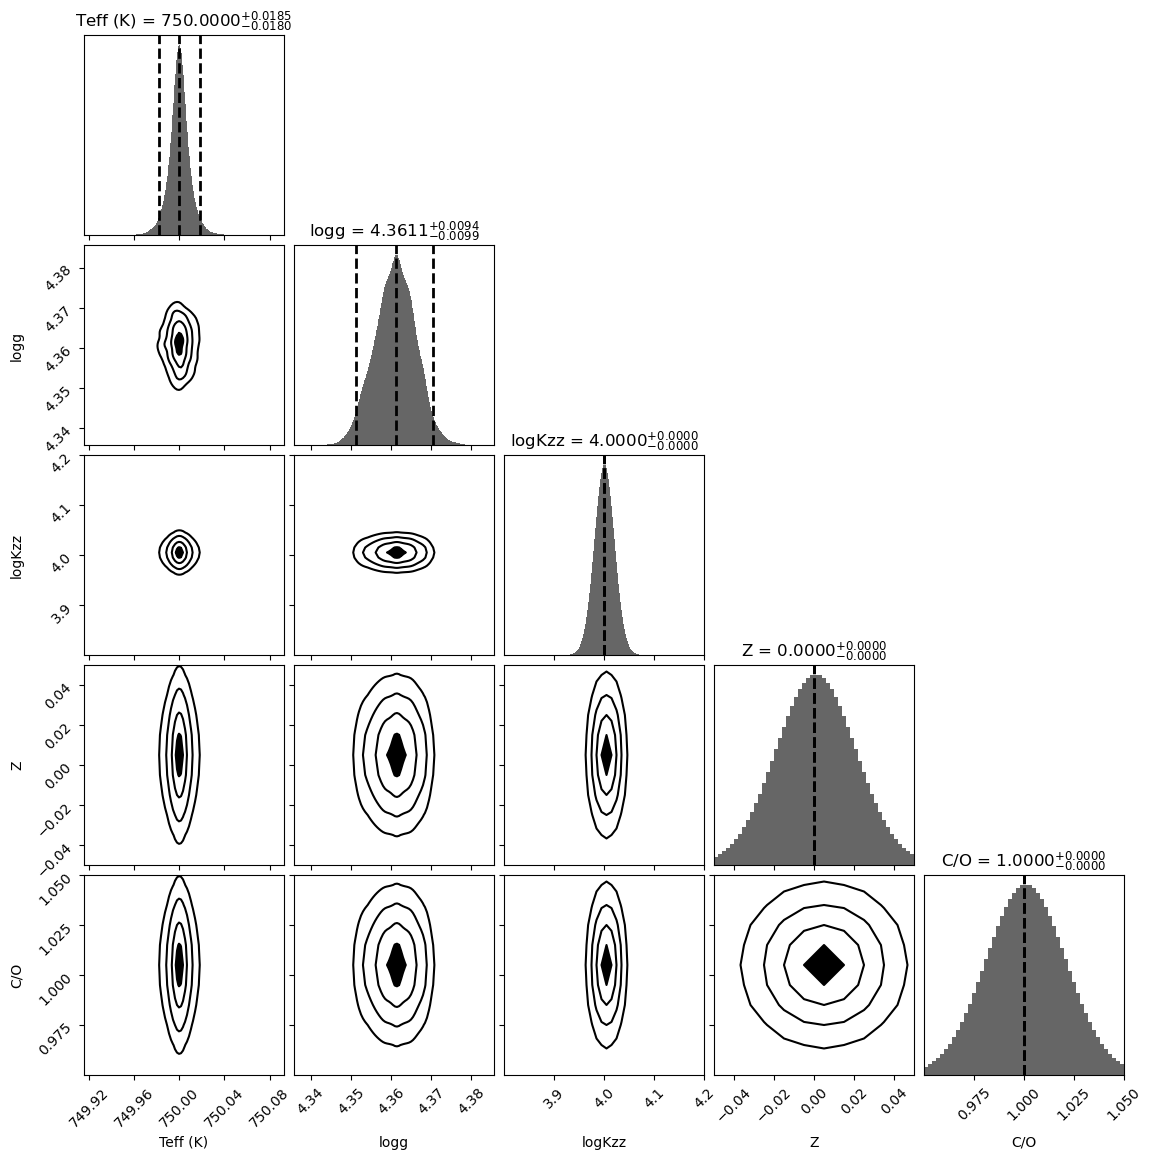

In [18]:
from dynesty import plotting as dyplot
from matplotlib import pyplot as plt

# truths = ['1.1', '790', '4.5', '2']
labels = ['Teff (K)', 'logg', 'logKzz', 'Z', 'C/O', 'R (Rj)']
fig, axes = dyplot.cornerplot(sresults, show_titles=True, #truths=truths, 
                              verbose='true', title_fmt='.4f', #, #.1f, .2f, .1f',
                              title_kwargs={'y': 1.0}, labels=labels)
#                               fig=plt.subplots(ndim, ndim, figsize=(7, 7)))

In [9]:
import pickle

# load saved variable with model grid
# sresults = None

# open the file in binary mode
with open('Sonora_Elf_Owl_nested_sampling.pickle', 'rb') as file:
    # deserialize and retrieve the variable from the file
    sresults = pickle.load(file)

print('variable loaded successfully')

variable loaded successfully


Quantiles:
Teff (K) [(0.025, 760.0312082194978), (0.5, 761.136363164648), (0.975, 762.2350772765587)]
Quantiles:
logg [(0.025, 4.523312445462627), (0.5, 4.531966229696976), (0.975, 4.540827232324171)]
Quantiles:
logKzz [(0.025, 3.9589396400806267), (0.5, 3.9928513259753924), (0.975, 4.000450169998497)]
Quantiles:
Z [(0.025, 0.08375452791722578), (0.5, 0.08813011563825936), (0.975, 0.09274704684188106)]
Quantiles:
C/O [(0.025, 1.1262243841295658), (0.5, 1.1347049217045948), (0.975, 1.1432972979013287)]
Quantiles:
R (Rj) [(0.025, 0.7987326491371034), (0.5, 0.8017157658183797), (0.975, 0.8048431043390425)]


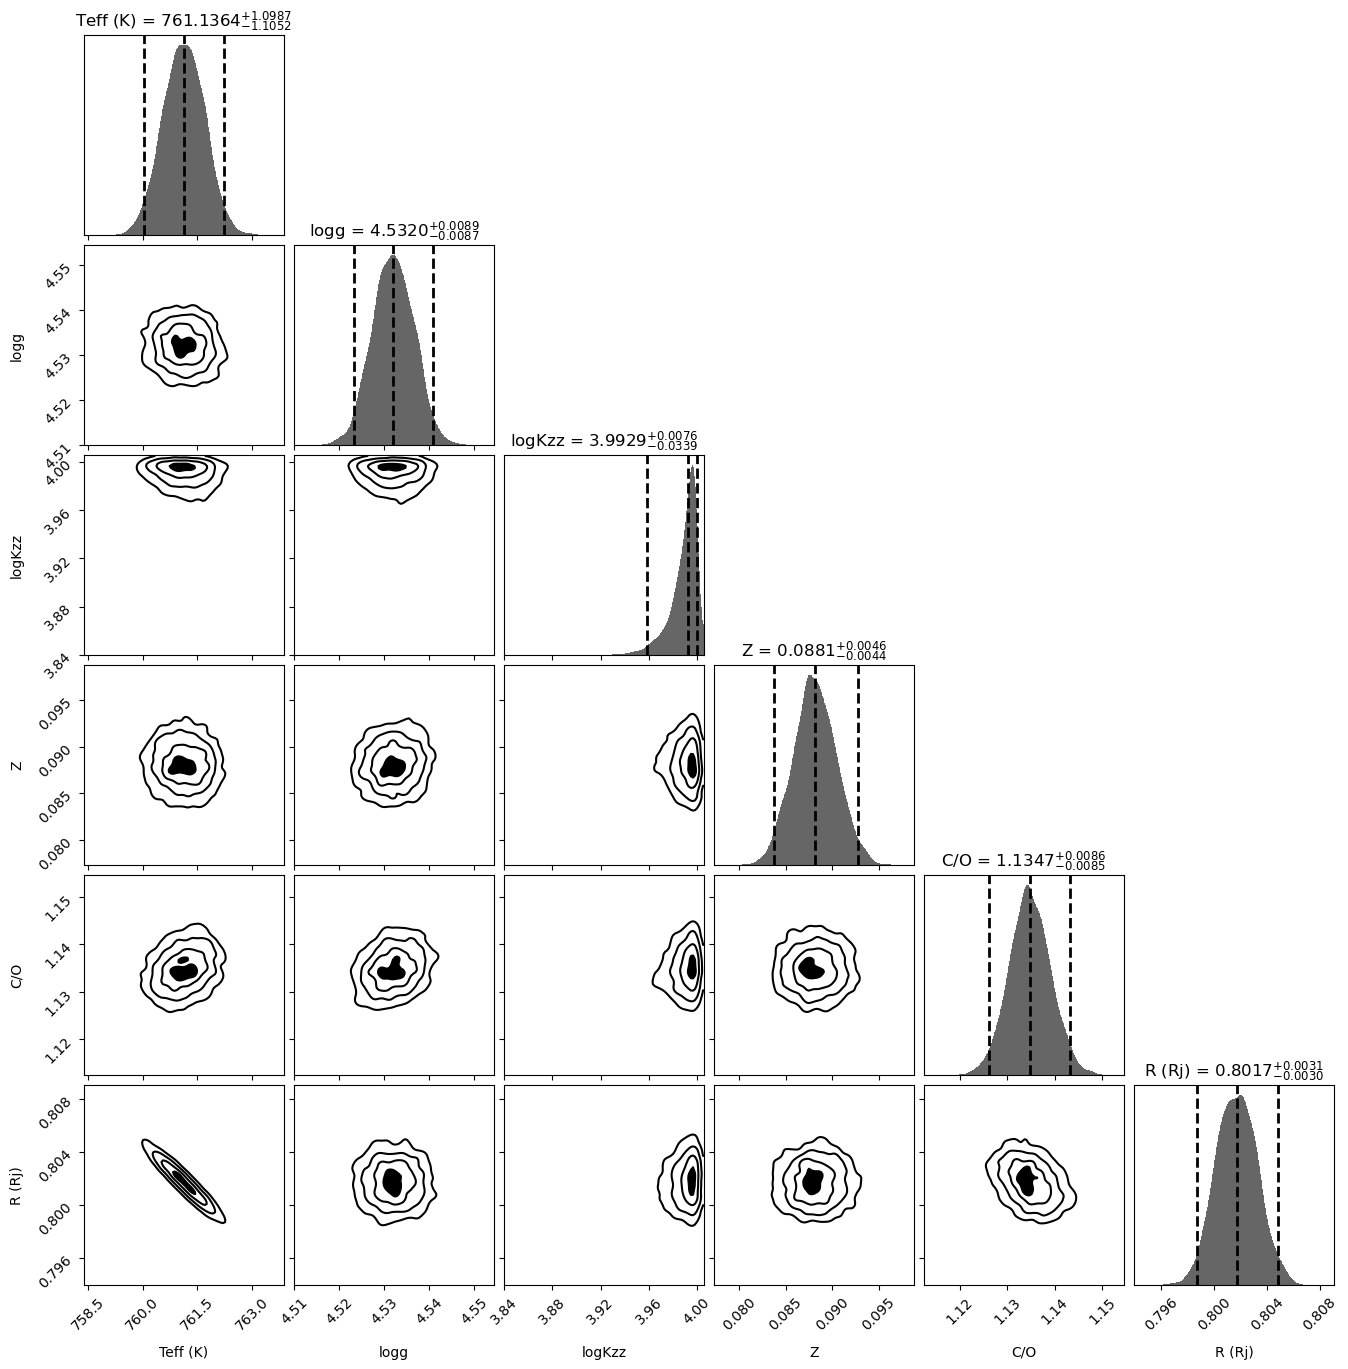

In [100]:
from dynesty import plotting as dyplot
from matplotlib import pyplot as plt

# truths = ['1.1', '790', '4.5', '2']
labels = ['Teff (K)', 'logg', 'logKzz', 'Z', 'C/O', 'R (Rj)']
fig, axes = dyplot.cornerplot(sresults, show_titles=True, #truths=truths, 
                              verbose='true', title_fmt='.4f', #, #.1f, .2f, .1f',
                              title_kwargs={'y': 1.0}, labels=labels)
#                               fig=plt.subplots(ndim, ndim, figsize=(7, 7)))

Quantiles:
Teff (K) [(0.025, 754.5647408140325), (0.5, 755.5762006313965), (0.975, 756.5465678187675)]
Quantiles:
logg [(0.025, 4.5), (0.5, 4.5), (0.975, 4.5)]


/home/gsuarez/TRABAJO/PROGRAMS/Anaconda/anaconda3/lib/python3.9/site-packages/dynesty/plotting.py:1320: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(span[i])
/home/gsuarez/TRABAJO/PROGRAMS/Anaconda/anaconda3/lib/python3.9/site-packages/dynesty/plotting.py:2393: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(span[1])


Quantiles:
logKzz [(0.025, 4.0), (0.5, 4.0), (0.975, 4.0)]
Quantiles:
Z [(0.025, 0.0), (0.5, 0.0), (0.975, 0.0)]


/home/gsuarez/TRABAJO/PROGRAMS/Anaconda/anaconda3/lib/python3.9/site-packages/dynesty/plotting.py:2392: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(span[0])


Quantiles:
C/O [(0.025, 1.0), (0.5, 1.0), (0.975, 1.0)]


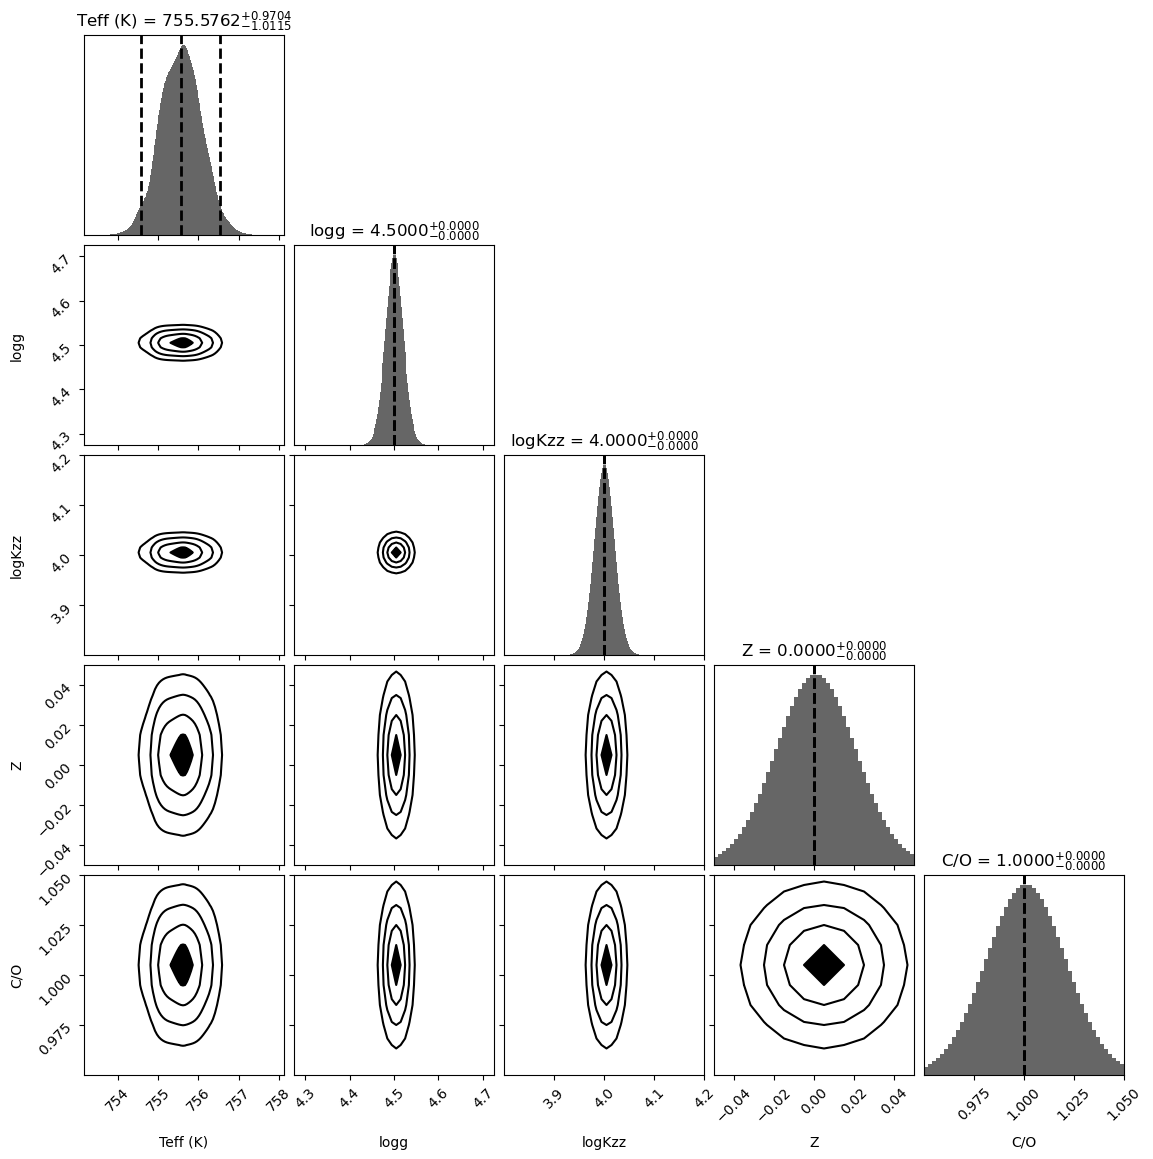

In [105]:
from dynesty import plotting as dyplot
from matplotlib import pyplot as plt

# truths = ['1.1', '790', '4.5', '2']
labels = ['Teff (K)', 'logg', 'logKzz', 'Z', 'C/O', 'R (Rj)']
fig, axes = dyplot.cornerplot(sresults, show_titles=True, #truths=truths, 
                              verbose='true', title_fmt='.4f', #, #.1f, .2f, .1f',
                              title_kwargs={'y': 1.0}, labels=labels)
#                               fig=plt.subplots(ndim, ndim, figsize=(7, 7)))

Quantiles:
Teff (K) [(0.025, 749.9820347464611), (0.5, 750.0000143151125), (0.975, 750.0184710324038)]
Quantiles:
logg [(0.025, 4.351252720493471), (0.5, 4.3611120328511355), (0.975, 4.37050274170949)]
Quantiles:
logKzz [(0.025, 4.0), (0.5, 4.0), (0.975, 4.0)]


/home/gsuarez/TRABAJO/PROGRAMS/Anaconda/anaconda3/lib/python3.9/site-packages/dynesty/plotting.py:1320: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(span[i])
/home/gsuarez/TRABAJO/PROGRAMS/Anaconda/anaconda3/lib/python3.9/site-packages/dynesty/plotting.py:2393: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(span[1])


Quantiles:
Z [(0.025, 0.0), (0.5, 0.0), (0.975, 0.0)]


/home/gsuarez/TRABAJO/PROGRAMS/Anaconda/anaconda3/lib/python3.9/site-packages/dynesty/plotting.py:2392: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(span[0])


Quantiles:
C/O [(0.025, 1.0), (0.5, 1.0), (0.975, 1.0)]


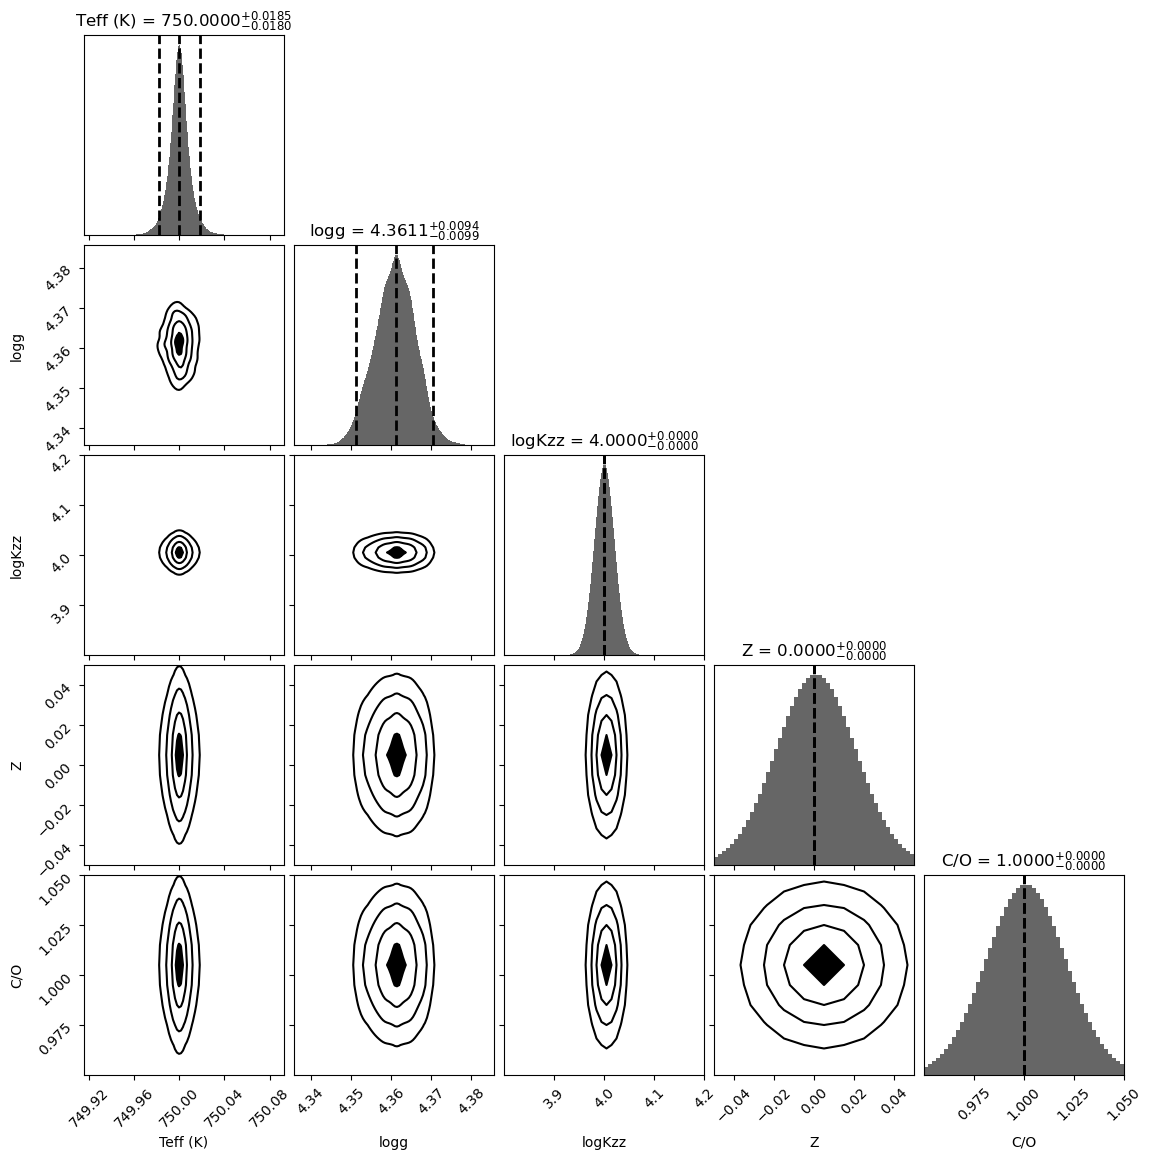

In [10]:
from dynesty import plotting as dyplot
from matplotlib import pyplot as plt

# truths = ['1.1', '790', '4.5', '2']
labels = ['Teff (K)', 'logg', 'logKzz', 'Z', 'C/O', 'R (Rj)']
fig, axes = dyplot.cornerplot(sresults, show_titles=True, #truths=truths, 
                              verbose='true', title_fmt='.4f', #, #.1f, .2f, .1f',
                              title_kwargs={'y': 1.0}, labels=labels)
#                               fig=plt.subplots(ndim, ndim, figsize=(7, 7)))

Quantiles:
Teff (K) [(0.025, 763.4483884027769), (0.5, 763.6676911377485), (0.975, 763.8997783179929)]
Quantiles:
logg [(0.025, 4.5), (0.5, 4.5), (0.975, 4.5)]
Quantiles:
logKzz [(0.025, 4.0), (0.5, 4.0), (0.975, 4.0)]
Quantiles:
Z [(0.025, 0.0), (0.5, 0.0), (0.975, 0.0)]
Quantiles:
C/O [(0.025, 1.0), (0.5, 1.0), (0.975, 1.0)]
Quantiles:
R (Rj) [(0.025, 0.7996515005007823), (0.5, 0.7999382478633063), (0.975, 0.7999976598888231)]


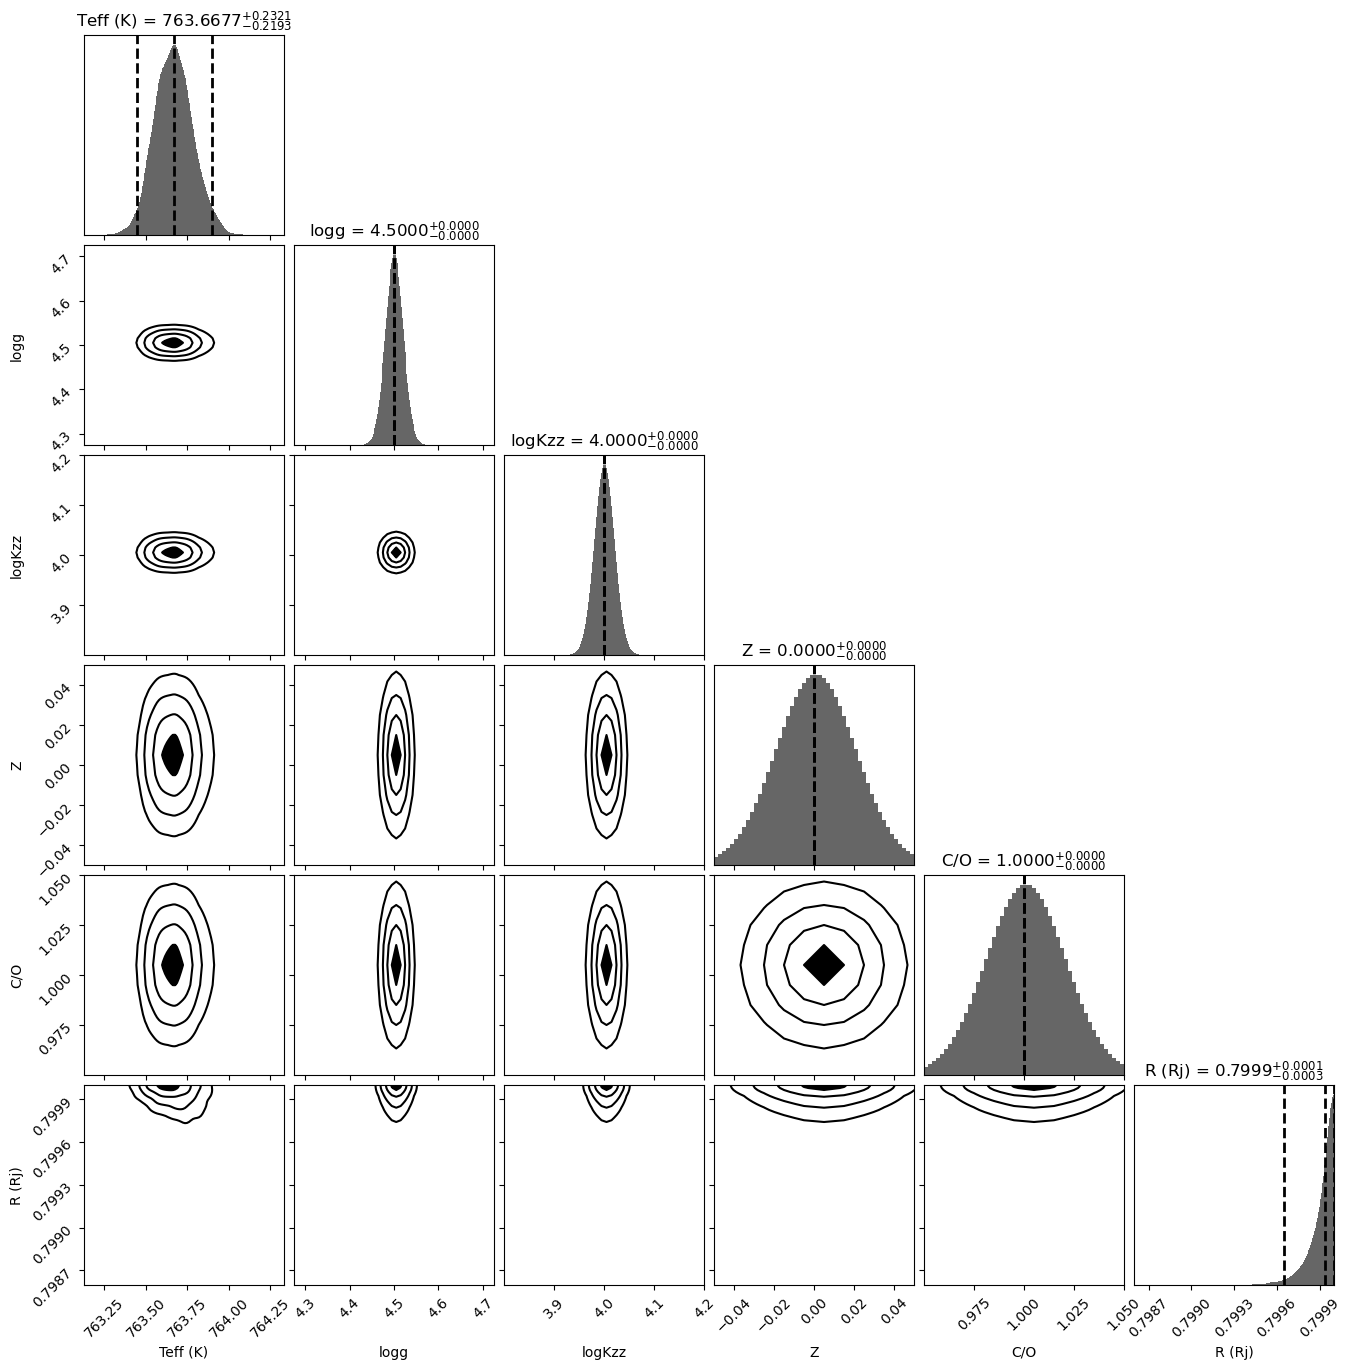

In [91]:
from dynesty import plotting as dyplot
from matplotlib import pyplot as plt

# truths = ['1.1', '790', '4.5', '2']
labels = ['Teff (K)', 'logg', 'logKzz', 'Z', 'C/O', 'R (Rj)']
fig, axes = dyplot.cornerplot(sresults, show_titles=True, #truths=truths, 
                              verbose='true', title_fmt='.4f', #, #.1f, .2f, .1f',
                              title_kwargs={'y': 1.0}, labels=labels)
#                               fig=plt.subplots(ndim, ndim, figsize=(7, 7)))

In [58]:
seda.__file__

'/home/gsuarez/TRABAJO/PROGRAMS/Python/bin/seda/seda/__init__.py'

INPUT PARAMETERS

In [1]:
# W0415
from astropy.io import fits, ascii
import numpy as np

model = 'Sonora_Elf_Owl'

d_target = 5.71 # pc (parallax=175.2+-1.7; Dupuy-Liu2012)
ed_target = 0.06 # pc

# read the grid constained with the parameters below
R_range = np.array((0.6, 0.8)) # Rjup
Teff_range = np.array((700, 900))
logg_range = np.array((4.0, 5.0))

# SpeX spectrum (the one Jackie send me and calibrated using the 2MASS photometry)
SpeX_name = '/home/gsuarez/TRABAJO/Postdoc/AMNH/projects/JWST_Program2124/other_data/W0415/SpeX_flux_calibration/SpeX_0415-0935.dat'
SpeX = ascii.read(SpeX_name)
wl_SpeX = SpeX['wl(um)'] # um 
flux_SpeX = SpeX['flux(erg/s/cm2/A)'] # erg/s/cm2/A
eflux_SpeX = SpeX['eflux(erg/s/cm2/A)'] # erg/s/cm2/A
# cut both edges
mask_SpeX = (flux_SpeX>4.587e-19) & (wl_SpeX<2.55252) & (wl_SpeX>0.66516)
wl_SpeX = wl_SpeX[mask_SpeX]
flux_SpeX = flux_SpeX[mask_SpeX]
eflux_SpeX = eflux_SpeX[mask_SpeX]
# remove the optical spectra because they look weird compared to the one by Keck/LRIS (Kirkpatrick+2008)
mask = wl_SpeX>0.9
wl_SpeX = wl_SpeX[mask]
flux_SpeX = flux_SpeX[mask]
eflux_SpeX = eflux_SpeX[mask]
# manage weird data points
mask = wl_SpeX==2.22724 # data point with an extremely low flux error (ef/f=1e-5)
eflux_SpeX[mask] = np.median(eflux_SpeX)

Read grid in the indicated ranges

In [26]:
import interpol_model as interpol_model
import seda as seda
import importlib

importlib.reload(interpol_model) # to automatically reload any changes in the function
importlib.reload(seda) # to automatically reload any changes in the function
grid = interpol_model.read_grid(model=model, Teff_range=Teff_range, logg_range=logg_range)


    SEDA package imported 


3000 spectra in memory to define a grid for interpolations
   elapsed time: 31.0 s


In [3]:
# importlib.reload(interpol_model) # to automatically reload any changes in the function
# interpol_model.interpol_Sonora_Elf_Owl(700, 4.5, 2.0, -1.0, 0.5, grid)

Run Dynasty

In [64]:
import sampling as sampling
import importlib

importlib.reload(sampling) # to automatically reload any changes in the function
out_sampling = sampling.sampling(grid=grid, wl_spectra=wl_SpeX, flux_spectra=flux_SpeX, eflux_spectra=eflux_SpeX, 
                                 Teff_range=Teff_range, logg_range=logg_range, R_range=R_range, model=model, 
                                 distance=d_target, dynamic_sampling='no')

   elapsed time running NestedSampler: 33.0 s


16655it [1:41:22,  2.74it/s, +500 | bound: 127 | nc: 1 | ncall: 113398 | eff(%): 15.195 | loglstar:   -inf < 6846.251 <    inf | logz: 6813.588 +/-  0.257 | dlogz:  0.001 >  0.509]

   elapsed time running run_nested: 1.7 hr
   elapsed time running sampler.results: 0.0 s
variable saved successfully


In [19]:
import pickle

# load saved variable with model grid
# sresults = None

# open the file in binary mode
with open('static_nested_Sonora_Elf_Owl.pickle', 'rb') as file:
    # deserialize and retrieve the variable from the file
    sresults = pickle.load(file)

print('variable loaded successfully')

variable loaded successfully


Quantiles:
R (Rj) [(0.025, 0.7790019638417581), (0.5, 0.7820393057341344), (0.975, 0.785235479464246)]
Quantiles:
Teff (K) [(0.025, 765.3319417281037), (0.5, 766.5654803926944), (0.975, 767.7360658843477)]
Quantiles:
logg [(0.025, 4.553631138182576), (0.5, 4.563002510659775), (0.975, 4.572325646105281)]
Quantiles:
logKzz [(0.025, 3.962150936981907), (0.5, 3.9938414401341644), (0.975, 4.000689129934625)]
Quantiles:
Z [(0.025, 0.06277524274537226), (0.5, 0.06727396155495556), (0.975, 0.07175752445926535)]
Quantiles:
C/O [(0.025, 1.1502742324949886), (0.5, 1.1592016754154078), (0.975, 1.167242803178663)]


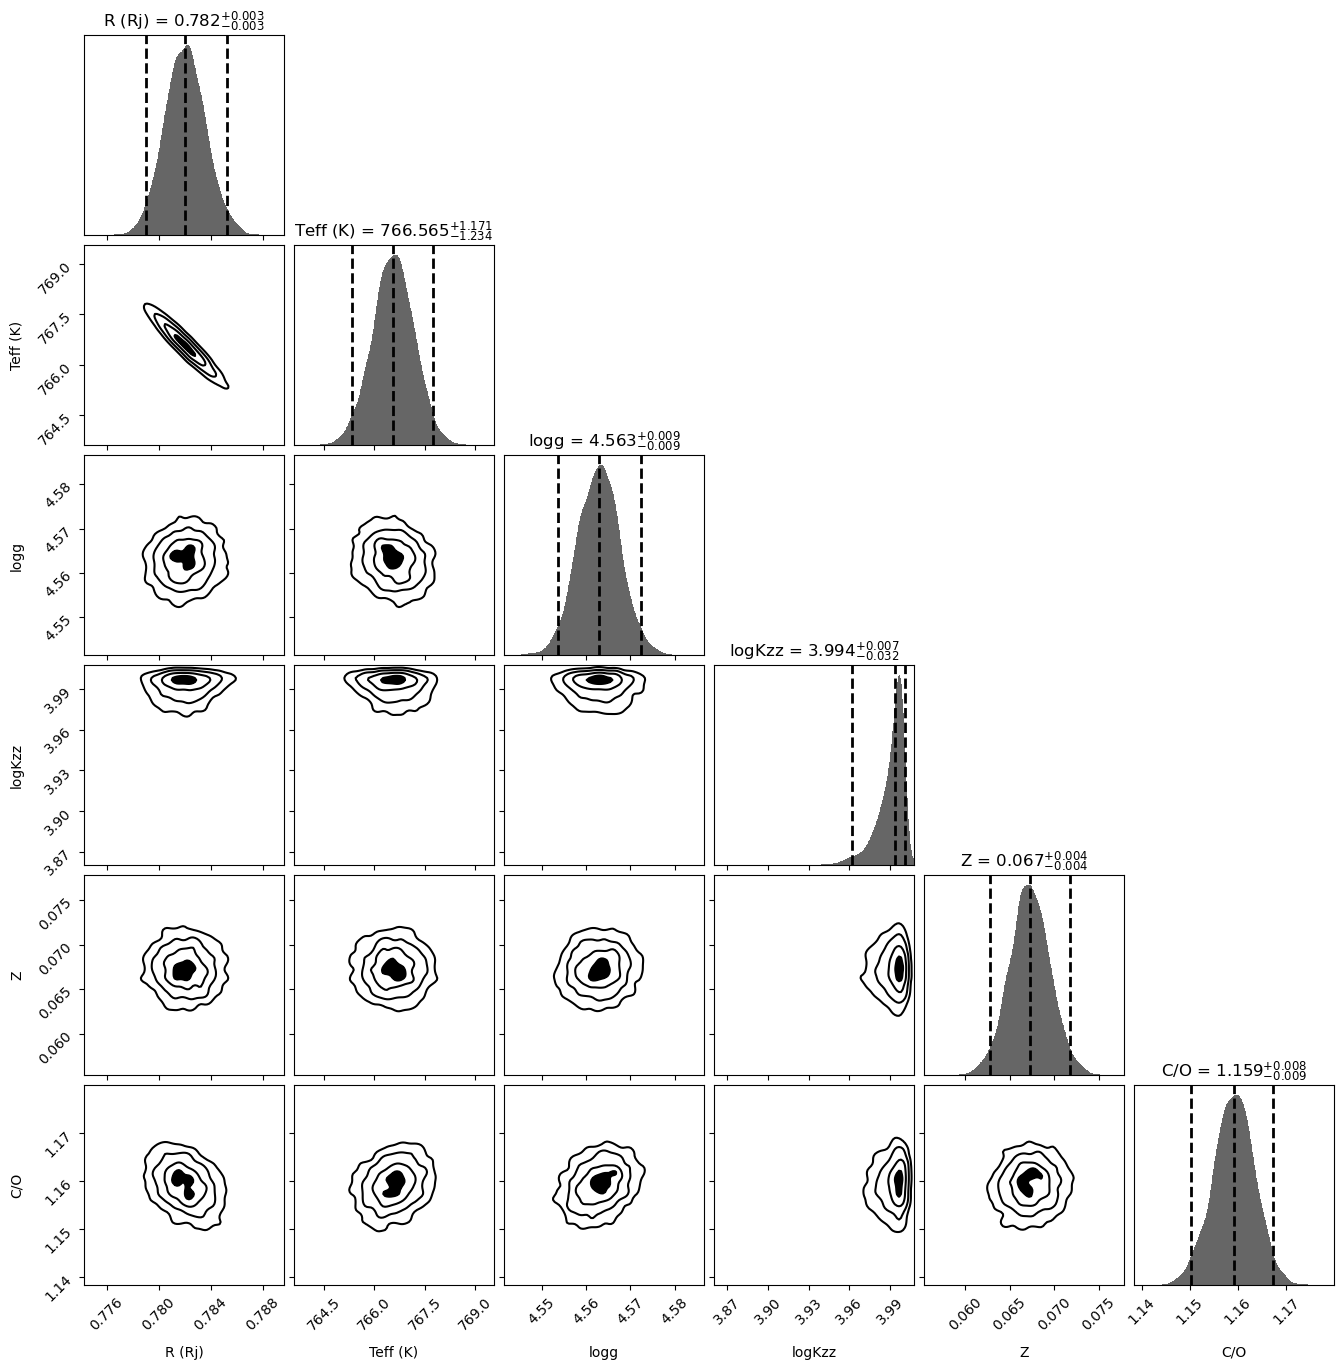

In [20]:
from dynesty import plotting as dyplot
from matplotlib import pyplot as plt

# truths = ['1.1', '790', '4.5', '2']
labels = ['R (Rj)', 'Teff (K)', 'logg', 'logKzz', 'Z', 'C/O']
fig, axes = dyplot.cornerplot(sresults, show_titles=True, #truths=truths, 
                              verbose='true', title_fmt='.3f', #, #.1f, .2f, .1f',
                              title_kwargs={'y': 1.0}, labels=labels)
#                               fig=plt.subplots(ndim, ndim, figsize=(7, 7)))

In [27]:
import sampling as sampling
import importlib

importlib.reload(sampling) # to automatically reload any changes in the function
out_sampling = sampling.sampling(grid=grid, wl_spectra=wl_SpeX, flux_spectra=flux_SpeX, eflux_spectra=eflux_SpeX, \
                                 Teff_range=Teff_range, logg_range=logg_range, R_range=R_range, model=model, \
                                 distance=d_target, dynamic_sampling='yes')


sampling the posterior...


199it [00:30, 15.98it/s, batch: 0 | bound: 0 | nc: 2 | ncall: 247 | eff(%): 26.640 | loglstar:   -inf < -243768.816 <    inf | logz: -243776.121 +/-  0.121 | dlogz: 235614.734 >  0.010]Traceback (most recent call last):
  File "/home/gsuarez/TRABAJO/PROGRAMS/Anaconda/anaconda3/lib/python3.9/site-packages/dynesty/dynesty.py", line 910, in __call__
    return self.func(np.asarray(x).copy(), *self.args, **self.kwargs)
  File "/home/gsuarez/TRABAJO/PROGRAMS/Python/bin/seda/sampling.py", line 80, in loglike
    flux_model = model_gen(p) # radius parameter could be excluded
  File "/home/gsuarez/TRABAJO/PROGRAMS/Python/bin/seda/sampling.py", line 71, in model_gen
    out_interpol_model = interpol_model.interpol_Sonora_Elf_Owl(Teff, logg, logKzz, Z, CtoO, grid)
  File "/home/gsuarez/TRABAJO/PROGRAMS/Python/bin/seda/interpol_model.py", line 47, in interpol_Sonora_Elf_Owl
    spectra_interpol_wl = interp_wl(params_interpol)[0,:] # to return a 1D array
  File "/home/gsuarez/TRABAJO/PROGRAMS/Anac

Exception while calling loglikelihood function:
  params: [6.45016426e-01 7.82919525e+02 4.17906125e+00 8.07455637e+00
 1.00327298e-01 7.73697833e-01]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [21]:
import pickle

# load saved variable with model grid
# sresults = None

# open the file in binary mode
with open('dynamic_nested_Sonora_Elf_Owl.pickle', 'rb') as file:
    # deserialize and retrieve the variable from the file
    dresults = pickle.load(file)

print('variable loaded successfully')

variable loaded successfully


Quantiles:
R (Rj) [(0.025, 0.7596892065546511), (0.5, 0.7627778966681014), (0.975, 0.7657267823588346)]
Quantiles:
Teff (K) [(0.025, 777.289342191817), (0.5, 778.525642207516), (0.975, 779.835116828708)]


/home/gsuarez/TRABAJO/PROGRAMS/Anaconda/anaconda3/lib/python3.9/site-packages/dynesty/plotting.py:1320: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(span[i])


Quantiles:
logg [(0.025, 4.5), (0.5, 4.5), (0.975, 4.5)]


/home/gsuarez/TRABAJO/PROGRAMS/Anaconda/anaconda3/lib/python3.9/site-packages/dynesty/plotting.py:2393: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(span[1])


Quantiles:
logKzz [(0.025, 3.0), (0.5, 3.0), (0.975, 3.0)]


/home/gsuarez/TRABAJO/PROGRAMS/Anaconda/anaconda3/lib/python3.9/site-packages/dynesty/plotting.py:2392: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(span[0])


Quantiles:
Z [(0.025, 0.0), (0.5, 0.0), (0.975, 0.0)]
Quantiles:
C/O [(0.025, 1.0), (0.5, 1.0), (0.975, 1.0)]


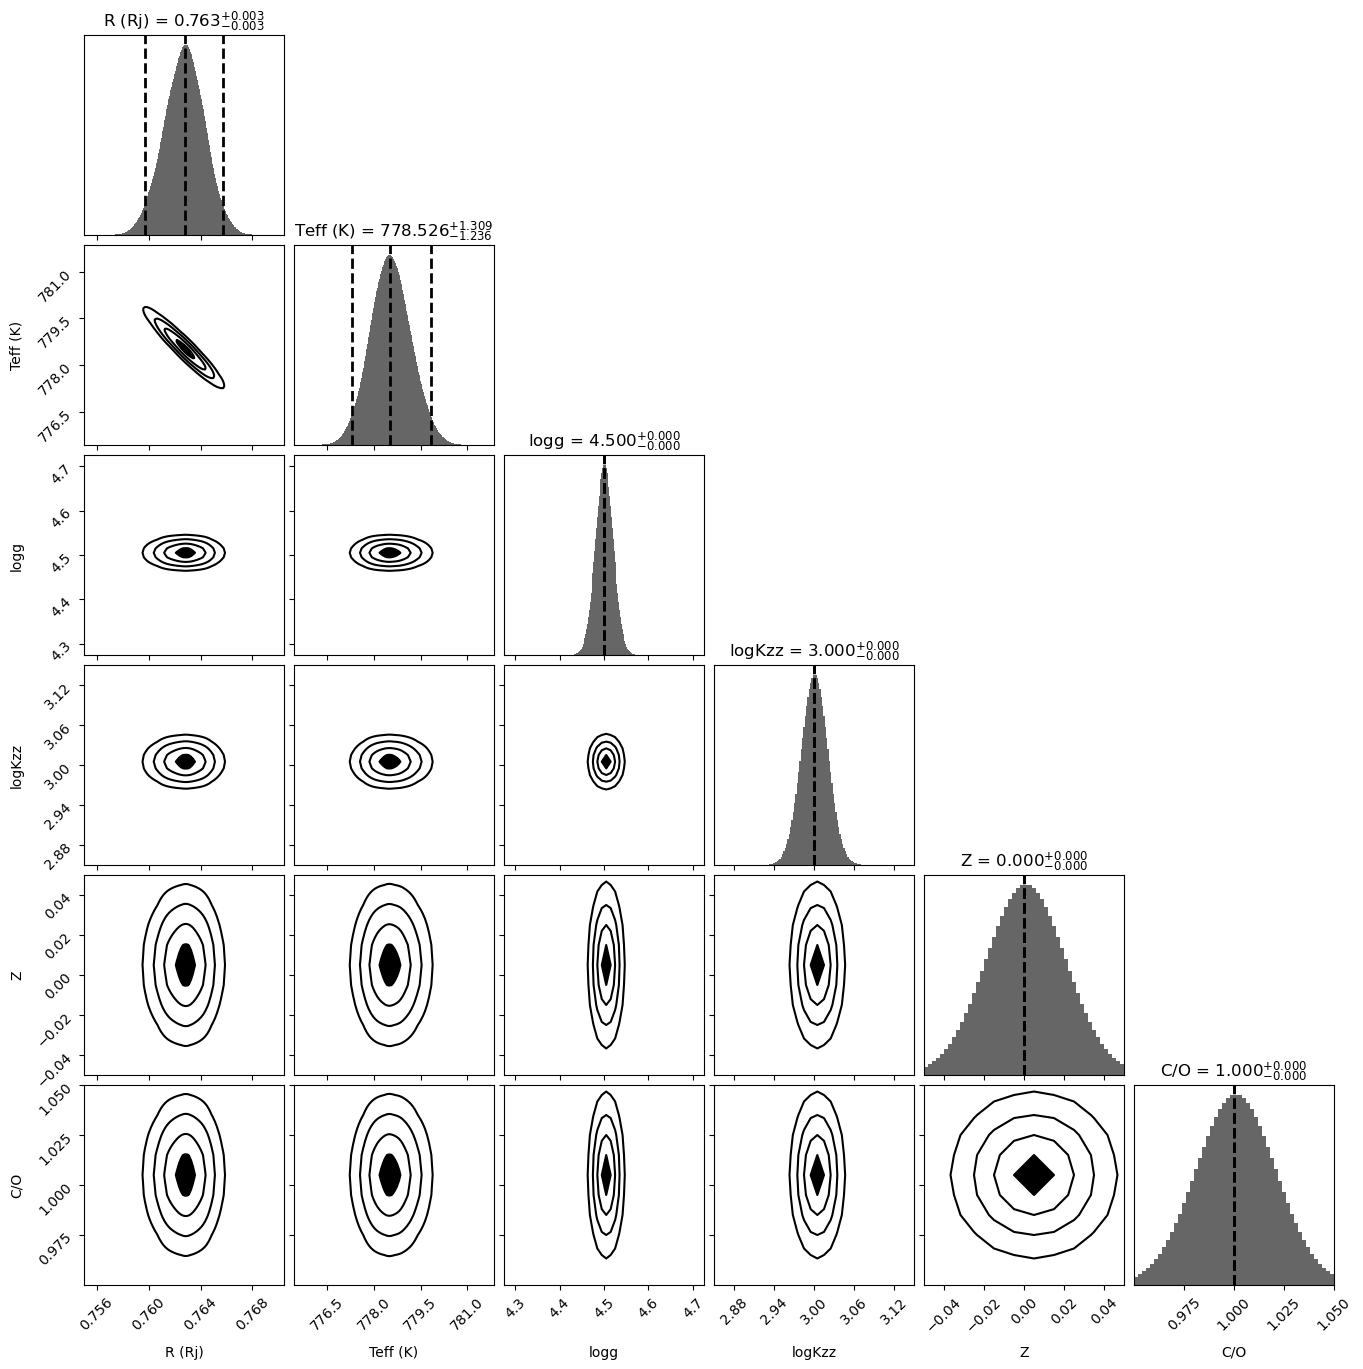

In [22]:
from dynesty import plotting as dyplot
from matplotlib import pyplot as plt

# truths = ['1.1', '790', '4.5', '2']
labels = ['R (Rj)', 'Teff (K)', 'logg', 'logKzz', 'Z', 'C/O']
fig, axes = dyplot.cornerplot(dresults, show_titles=True, #truths=truths, 
                              verbose='true', title_fmt='.3f', #, #.1f, .2f, .1f',
                              title_kwargs={'y': 1.0}, labels=labels)
#                               fig=plt.subplots(ndim, ndim, figsize=(7, 7)))

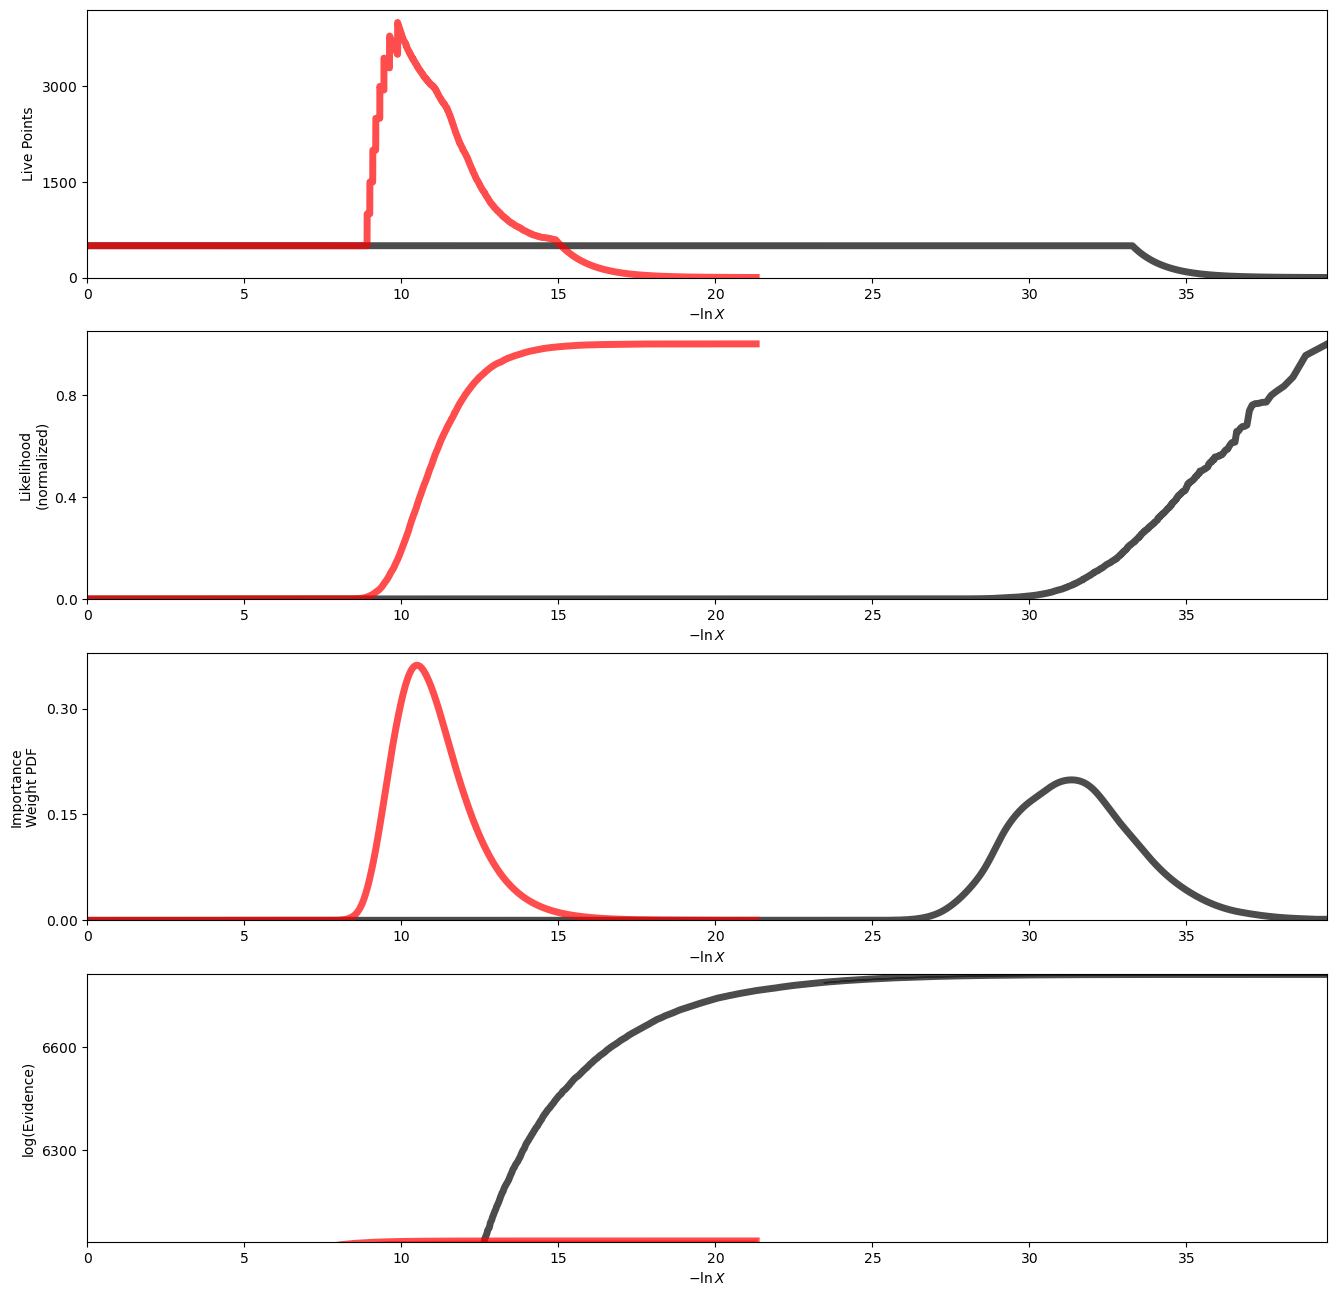

In [23]:
# plot static run with fixed number of live points
fig, axes = dyplot.runplot(sresults, color='black', mark_final_live=False, logplot=True)

# overplot default dynamic run
fig, axes = dyplot.runplot(dresults, color='red',
                           logplot=True, fig=(fig, axes))